# Question 1:  Pose Graph Optimization for 1D SLAM

A solved example for 1D SLAM which optimizes for pose variables using weighted least squares method (Gauss Newton) has been explained in the class. You can view it at `examples/1D-SLAM.ipynb`. Your first task is to code this from scratch.

For this section, you have to calculate Jacobian analytically yourself and use it. However, you can check how correct it is using `jax`'s `jacobian`. Its usage is explained in the supplementary notebook (`examples/`).

## How to get started?

1. Go through the example and understand the optimization procedure.
2. Generate the data as in the example.
3. Write the derivatives of the function with respect to the constraints
4. Create the final jacobian and write the update steps using Gauss Newton

This tiny example will help make sense of the next question, as it's largely just an extension of this.

Finally, plot the loop closure constraint, poses, and error at every iteration as well. Since this is a one dimensional example, you can just assume x = y.

In [1]:
import os
import math
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Code!
def get_observations( X , loop_closure_index ):
    pre = []
    post =[]
    observations = []
    for lc in loop_closure_index:
        pre.append( lc[0] )
        post.append( lc[1] )    
    
    for i in range( 1, len(X) + len(pre) ):
        if (i < len(X)):
            observations.append(X[i])
        if( i>=len(X) ):
            observations.append( X[ post[i - len(X) ] ] )
    
    return observations

def get_predictions( X,u ,loop_closure_index ):
    pre = []
    post =[] 
    predictions = []
    for lc in loop_closure_index:
        pre.append( lc[0] )
        post.append( lc[1] )    
    curr_state = 0
    
    for i in range(  len(u) ):
        if( curr_state < len(X)-1 ):
            p =X[i] + u[i]
            predictions.append(p)
            curr_state +=1
        else:   
            p = X[ pre[ i - curr_state ]  ] + u[i]
            predictions.append(p)
            
    return predictions

def determine_error( predictions, observations  ):
    predictions = np.asarray(predictions)
    observations = np.asarray(observations)
    error = predictions -observations
    error  =np.append( error, 0)
    
    return error

def get_jacobian():
    J = np.array([ [ 1 ,-1 , 0, 0 , 0] ,
                 [ 0 ,1 ,-1, 0 ,0 ] ,
                 [0 ,0 , 1 , -1 , 0] , 
                 [0 ,0 ,0 ,1,-1 ] , 
                 [1 ,0,0,0,-1] ,
                 [1,0,0,0,0 ] ])
    
    return J

In [3]:
X = np.array( [ 0 ,1.1 , 2.1 ,3.2 ,0.5 ] )
u = np.array( [ 1.1 , 1 ,1.1 , -2.7 , 0 ] )
loop_closure_index = [ (0,4) ]
observations  = get_observations( X , loop_closure_index )
predictions = get_predictions( X,u ,loop_closure_index )

print( observations)
print(predictions )

[1.1, 2.1, 3.2, 0.5, 0.5]
[1.1, 2.1, 3.2, 0.5, 0.0]


[6.93514181e-18 1.00000010e+00 1.90000019e+00 2.90000029e+00
 1.00000381e-01]


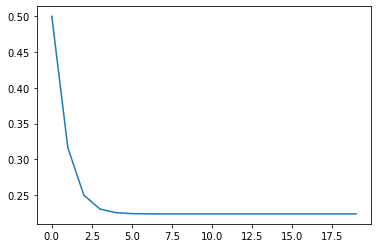

In [4]:
iterations = 20
error_data = []
for j in range(iterations):
    error = determine_error( predictions, observations  )
    error_data.append( np.linalg.norm( error ) )
    J = get_jacobian()
    dim = np.shape(error)[0]
    omega = np.zeros( ( dim, dim )  )
    omega[0][0] = omega[1][1] = omega[2][2] = omega[3][3] = omega[4][4] = 0.01
    omega[5][5] = 0.001 
    omega = np.linalg.inv(omega)
    
    H = J.T@omega@J
    b = J.T@omega.T@error
    
    del_x = np.linalg.inv(H)@(-b)
    X += 0.5*del_x 
    observations  = get_observations( X , loop_closure_index )
    predictions = get_predictions( X,u ,loop_closure_index )  
    
print(X)

plt.plot( np.arange( 0, iterations ,1 ) , error_data  )
plt.show()